# Word usage by multiple artists

It obtains all lyrics for a given set of artists (parses HTML from www.metrolyrics.com) and returns a comparision of the words used by the artists.
Packages required: requests | re | time |

In [1]:
import sys
sys.path.insert(0, '../src')
from lyricsFunctions import *

In [2]:
listOfArtists = ['Eddie Vedder', 'Dire Straits', 'Ed Sheeran']
songs4Artists = getSongs4Artists(listOfArtists) #by default (location = 'online')
#songs4Artists['eddie-vedder'] # Check artist songs found

Fetching eddie-vedder songs online ...
http://www.metrolyrics.com/eddie-vedder-lyrics.html
Fetching dire-straits songs online ...
http://www.metrolyrics.com/dire-straits-lyrics.html
Fetching ed-sheeran songs online ...
http://www.metrolyrics.com/ed-sheeran-lyrics.html
Done!


For each artist, collect all words across all song lyrics:

In [3]:
lyrics4Artists = getLyrics4Artists(songs4Artists, numSongs = 20) # by default (numSongs = 5 | location = 'online')

Fetching 20 lyrics for eddie-vedder ...
Fetching 20 lyrics for dire-straits ...
Fetching 20 lyrics for ed-sheeran ...
Done!


Word extraction from artists lyrics and model generation:

In [4]:
m, cv, tf, vec = buildNaiveBayesModel(lyrics4Artists) #use spacy for lemmatization and token

What is the probability of each of the artist to write the following songs?

In [5]:
test_songs = [
      "I played the blues on twelve bars down on Lover's Lane",
      "I'll keep on healing all the scars That we've collected from the start",
      "So, baby, now Take me into your loving arms",
      "with a little help from my crocodile",
      "oh sweet love, what is this",
      "the beautiful people"]

prediction, classProb, logProb = proba_Lyrics4Artists(test_songs, m, cv, tf)


 Test songs might belong to:
['dire-straits' 'eddie-vedder' 'ed-sheeran' 'ed-sheeran' 'ed-sheeran'
 'eddie-vedder']

 Each song probability from being from each artist:
[[0.3865006  0.33648733 0.27701207]
 [0.29003041 0.29749433 0.41247526]
 [0.30676424 0.48967726 0.2035585 ]
 [0.3198727  0.3718244  0.3083029 ]
 [0.28260399 0.42759013 0.28980588]
 [0.32111027 0.33880998 0.34007974]]
[[-7.15047356 -7.37283705 -7.59076216 ... -7.59076216 -7.59076216
  -7.59076216]
 [-7.4945301  -7.58379012 -7.58379012 ... -7.54326541 -7.56062781
  -7.56062781]
 [-7.44219507 -7.54760373 -7.40334085 ... -7.57654829 -7.57654829
  -7.57654829]]


# Which world is characteristic of each artist?

## Bag of Words

In [6]:
allWordsEddieVedder = " ".join(lyrics4Artists['eddie-vedder'])
allWordsDireStraits = " ".join(lyrics4Artists['dire-straits'])
allWordsEdSheeran = " ".join(lyrics4Artists['ed-sheeran']) 

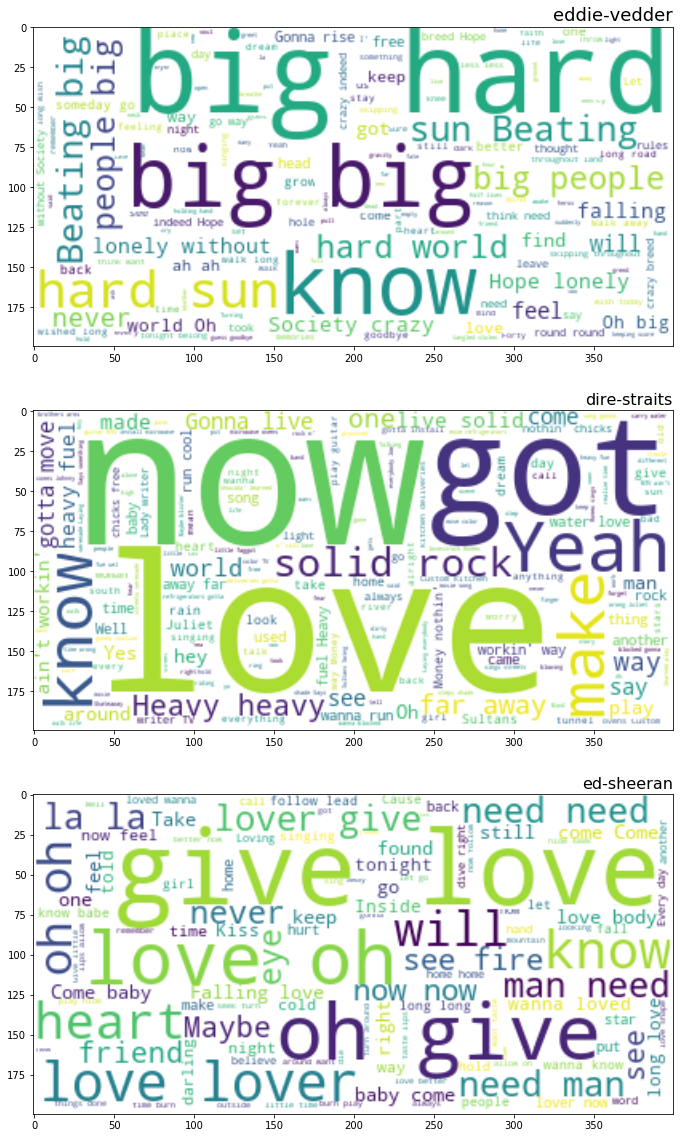

In [10]:
import wordcloud
import matplotlib.pyplot as plt
plt.figure(num = None, figsize = (20,20))

wordcloud1 = wordcloud.WordCloud(background_color="white", max_words=2000, contour_color='steelblue').generate(allWordsEddieVedder)
plt.subplot(3,1,1)
plt.title('eddie-vedder', fontsize=18, loc='right')
plt.imshow(wordcloud1, interpolation='bilinear')

wordcloud2 = wordcloud.WordCloud(background_color="white", max_words=2000, contour_color='steelblue').generate(allWordsDireStraits)
plt.subplot(3,1,2)
plt.title('dire-straits', fontsize=16, loc='right')
plt.imshow(wordcloud2, interpolation='bilinear')

wordcloud3 = wordcloud.WordCloud(background_color="white", max_words=2000, contour_color='steelblue').generate(allWordsEdSheeran)
plt.subplot(3,1,3)
plt.title('ed-sheeran', fontsize=16, loc='right')
plt.imshow(wordcloud3, interpolation='bilinear')
plt.show()

## Vocabulary that better charaterize the difference between artists

In [8]:
#### Latent Dirichlet Allocation
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd
wordVectors4Artists = list(sorted(cv.vocabulary_.keys()))

lda = LatentDirichletAllocation(n_components=10)
lda.fit(vec)
c = lda.components_

ctrans = c.T

df = pd.DataFrame(ctrans, index=wordVectors4Artists)

for i in range(10):
    print(df[i].sort_values(ascending=False).head(20))

skipping      0.675829
throughout    0.387880
land          0.342753
stumbling     0.326242
leave         0.292685
drunk         0.279192
while         0.277261
senses        0.269542
collide       0.269542
again         0.261750
king          0.243838
hearts        0.242774
promise       0.242464
friends       0.224452
men           0.221182
holding       0.213909
lost          0.201388
head          0.198485
friend        0.188881
remember      0.176208
Name: 0, dtype: float64
ah          0.802254
far         0.784831
long        0.554176
over        0.406263
la          0.378696
feel        0.360418
wanna       0.341748
told        0.290992
open        0.275621
knows       0.275441
meet        0.275130
guide       0.247322
horizons    0.247322
america     0.247322
cells       0.247065
universe    0.247065
reload      0.238551
aim         0.238551
thought     0.236611
lover       0.235148
Name: 1, dtype: float64
the     8.777080
you     7.631749
and     6.023903
my      5.452696
me  

In [9]:
### Principal components 

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

wordVectors4Artists = list(sorted(cv.vocabulary_.keys()))

pca = PCA(n_components=3)
logProb_T = np.transpose(logProb)
c = pca.fit_transform(logProb_T)
ctrans = c.T
df = pd.DataFrame(c, index=wordVectors4Artists)
#print(df)
varianceDf = pd.DataFrame(pca.explained_variance_ratio_, index = ['variance_ratio PC-1','variance_ratio PC-2','variance_ratio PC-3'])
print(varianceDf)

for i in range(3):
    print("\n Principal component " + str(i + 1) + " holds "+ str(varianceDf.iloc[i,0]) + " of the variation \n")
    print(df[i].sort_values(ascending=False).head(20))


                            0
variance_ratio PC-1  0.668656
variance_ratio PC-2  0.185121
variance_ratio PC-3  0.146223

 Principal component 1 holds 0.6686558181940345 of the variation 

the     2.192395
you     2.058312
and     1.760339
my      1.510295
me      1.494202
to      1.328360
in      1.248636
we      1.123410
of      1.042929
love    1.028853
it      0.991263
that    0.972576
on      0.951710
all     0.919538
your    0.893228
for     0.841505
but     0.800539
ll      0.799820
be      0.795590
so      0.763610
Name: 0, dtype: float64

 Principal component 2 holds 0.1851214267010359 of the variation 

he          0.625021
do          0.421751
heavy       0.410614
rock        0.408463
gotta       0.396610
these       0.387653
sultans     0.369507
water       0.359798
solid       0.348523
ain         0.339759
then        0.323533
tv          0.322766
juliet      0.306699
song        0.306086
she         0.299289
it          0.296428
play        0.294604
move        0.277992
br